# **Import Libraries**

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
import sklearn
import torchvision
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import seaborn as sns
import glob
from pathlib import Path
import cv2
torch.manual_seed(1)
np.random.seed(1)
import re
import pydicom
import math
from pydicom.pixel_data_handlers.util import apply_voi_lut
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_auc_score

In [2]:
IMAGE_SIZE = 256
NUM_IMAGES = 64
BATCH_SIZE= 4

# **Data Loading and Visualizations**

In [3]:
# Loade each individual MRI image
def loading_image(path, img_size=IMAGE_SIZE):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    data = apply_voi_lut(dicom.pixel_array, dicom)
    data = cv2.resize(data, (img_size, img_size))
    return data

In [4]:
# Loads in the Data as 3d slides for feeding into the model
def load_3d_image(idx, mri_type, num_imgs=NUM_IMAGES, split='train'):
    files = sorted(glob.glob(f"../input/rsna-miccai-brain-tumor-radiogenomic-classification/{split}/{idx}/{mri_type}/*.dcm"), 
                   key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])
    middle = int(len(files) / 2)
    half_num_imgs = int(num_imgs / 2)
    start = max(0, middle - half_num_imgs)
    end = min(len(files) + 1, middle + half_num_imgs)
    arrays = [loading_image(f) for f in files[start:end]]

    img3d = np.stack(arrays, axis=2)
    
    if img3d.shape[-1] < num_imgs:
        n_zero = np.zeros((IMAGE_SIZE, IMAGE_SIZE, num_imgs - img3d.shape[-1]))
        img3d = np.concatenate((img3d,  n_zero), axis=-1)
        
    if np.min(img3d) < np.max(img3d):
        img3d = img3d - np.min(img3d)
        img3d = img3d / np.max(img3d)

    return img3d

In [5]:
train_labels = pd.read_csv('../input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv')

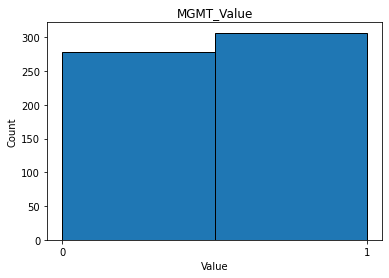

In [6]:
plt.hist(train_labels['MGMT_value'], bins=2, edgecolor='black')

# Setting the title and labels
plt.title("MGMT_Value")
plt.xlabel("Value")
plt.ylabel("Count")

# Remove the gaps between the bars
plt.gca().set_xticks([0, 1])  # Setting x-axis ticks to only 0 and 1

plt.show()

In [7]:
train_labels

,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1
...,...,...
580,1005,1
581,1007,1
582,1008,1
583,1009,0


In [8]:
(train_labels.MGMT_value == 1).sum()

307

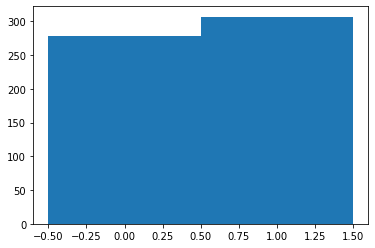

In [9]:
data = train_labels['MGMT_value']

d = np.diff(np.unique(data)).min()
left_of_first_bin = data.min() - float(d)/2
right_of_last_bin = data.max() + float(d)/2
plt.hist(data, np.arange(left_of_first_bin, right_of_last_bin + d, d))
plt.show()

In [10]:
train_files = sorted(os.listdir('../input/rsna-miccai-brain-tumor-radiogenomic-classification/train'))

In [11]:
len(train_files)

585

In [12]:
train_files = pd.Series(train_files, name='train_files')

In [13]:
train_labels = pd.concat([train_labels, train_files], axis=1)

In [14]:
train_labels

,BraTS21ID,MGMT_value,train_files
0,0,1,00000
1,2,1,00002
2,3,0,00003
3,5,1,00005
4,6,1,00006
...,...,...,...
580,1005,1,01005
581,1007,1,01007
582,1008,1,01008
583,1009,0,01009


In [15]:
train_labels = train_labels[train_labels['BraTS21ID'] != 109]

In [16]:
train_labels = train_labels[train_labels['BraTS21ID'] != 709]

109 and 709 don't have flair images so for this dataset. 

In [17]:
train_labels['MGMT_value'].value_counts()

1    306
0    277
Name: MGMT_value, dtype: int64

Fairly balanced train set.

In [18]:
test_data = pd.read_csv('../input/rsna-miccai-brain-tumor-radiogenomic-classification/sample_submission.csv')
test_ids = []
for f in test_data.itertuples():
    test_ids.append(f[1])

# **Dataset and DataLoader**

In [19]:
# Formatting and arranging data for model
class TumorDataset(torch.utils.data.Dataset):
    def __init__(self, df=train_labels, transform=transforms.Compose([transforms.ToTensor()]), mri_type="FLAIR", train=True):
        self.df = df
        self.transform = transform
        self.type = mri_type
        self.train = train
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
            if self.train == True:
                patient_id = self.df.iloc[idx, 2]
                
                image = load_3d_image(str(patient_id), self.type)
                image = self.transform(image)
                image = image[None, :, :, :]
                label = self.df.iloc[idx, 1]
                label = torch.tensor(label)
                
                return image, label
            
            else:
                patient_id = self.df[idx]
                patient_id = str(patient_id)
                for i in range(5 - len(patient_id)):
                    patient_id = '0' + patient_id
                
                
                image = load_3d_image(patient_id, self.type, split='test')
                image = self.transform(image)
                image = image[None, :, :, :]
                
                return image, idx

In [20]:
train_dataset = TumorDataset()
test_dataset = TumorDataset(df=test_ids, train=False)

In [21]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=4)

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# **Simple Model Architecture**

# 3D CNN

In [23]:
class ThreeDNetwork(nn.Module):
    
    def conv_layer(self, in_channels, out_channels, kernel_size, stride=2):
        conv_layer = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size, stride=stride),
            nn.LeakyReLU(),
            nn.MaxPool3d((2, 2, 2)),
            nn.BatchNorm3d(out_channels))
        return conv_layer
    
    def __init__(self, batch_size=BATCH_SIZE):
        super(ThreeDNetwork, self).__init__()
        self.batch_size = batch_size
        self.block1 = nn.Sequential(
            self.conv_layer(1, 64, 3, 2),
            self.conv_layer(64, 128, 3, 2))
        
        self.fc = nn.Sequential(
            nn.Linear(86400, 1024),
            nn.LeakyReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.2),
            nn.Linear(1024, 1))
        
    def forward(self, x):
        x = self.block1(x)
        x = x.view(-1, 86400)
        x = self.fc(x)
        return x

In [24]:
model = ThreeDNetwork()

In [25]:
print(model)

ThreeDNetwork(
  (block1): Sequential(
    (0): Sequential(
      (0): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2))
      (1): LeakyReLU(negative_slope=0.01)
      (2): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
      (3): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2))
      (1): LeakyReLU(negative_slope=0.01)
      (2): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
      (3): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (fc): Sequential(
    (0): Linear(in_features=86400, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=1024, out_featu

### **Training**

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_criterion = nn.BCELoss()
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=4, cooldown=2, verbose=True)

model = model.to(device)
train_criterion = train_criterion.to(device)

In [27]:
num_epochs = 25

accumulated_losses = []
accuracy_history = []  # To store accuracy for each epoch
recorded_best_loss = float('inf')

for current_epoch in range(num_epochs): 
    print(f'Epoch: {current_epoch + 1}')
    batch_losses = []
    epoch_loss_avg = 0
    correct_predictions = 0
    total_predictions = 0
    
    for imgs, labels in train_loader:
        optimizer.zero_grad()
        
        labels_transformed = labels.view(-1, 1).to(torch.float).to(device)
        imgs = imgs.float().to(device)
        
        predictions = model(imgs)
        predictions = torch.sigmoid(predictions)
        loss = train_criterion(predictions, labels_transformed)
        
        loss.backward()
        optimizer.step()
        
        batch_losses.append(loss.item())

        # For accuracy calculation, assuming binary classification and rounding predictions
        predicted_classes = predictions.round().to(device)
        correct_predictions += (predicted_classes == labels_transformed).sum().item()
        total_predictions += labels_transformed.size(0)
            
    epoch_loss_avg = np.mean(batch_losses)
    epoch_accuracy = (correct_predictions / total_predictions) * 100
    accuracy_history.append(epoch_accuracy)  # Append accuracy of this epoch to the history
    
    print(f'Epoch {current_epoch + 1}, Training Loss: {epoch_loss_avg:.4f}, Training Accuracy: {epoch_accuracy:.2f}%')
    
    if epoch_loss_avg < recorded_best_loss:
        torch.save(model.state_dict(), 'updated_model.pth')
        print('Model performance improved. Saving the new model.')
        recorded_best_loss = epoch_loss_avg
        
    lr_scheduler.step(epoch_loss_avg)
    accumulated_losses.append(epoch_loss_avg)



Epoch: 1
Epoch 1, Training Loss: 0.9221, Training Accuracy: 49.91%
Model performance improved. Saving the new model.
Epoch: 2
Epoch 2, Training Loss: 0.6920, Training Accuracy: 60.03%
Model performance improved. Saving the new model.
Epoch: 3
Epoch 3, Training Loss: 0.6079, Training Accuracy: 66.72%
Model performance improved. Saving the new model.
Epoch: 4
Epoch 4, Training Loss: 0.5476, Training Accuracy: 71.87%
Model performance improved. Saving the new model.
Epoch: 5
Epoch 5, Training Loss: 0.4983, Training Accuracy: 75.13%
Model performance improved. Saving the new model.
Epoch: 6
Epoch 6, Training Loss: 0.4596, Training Accuracy: 75.64%
Model performance improved. Saving the new model.
Epoch: 7
Epoch 7, Training Loss: 0.4387, Training Accuracy: 78.56%
Model performance improved. Saving the new model.
Epoch: 8
Epoch 8, Training Loss: 0.3985, Training Accuracy: 82.16%
Model performance improved. Saving the new model.
Epoch: 9
Epoch 9, Training Loss: 0.3833, Training Accuracy: 82.1

### Testing

In [28]:
def rounding(num):
    return math.floor(num + 0.5)

In [29]:
model.load_state_dict(torch.load('updated_model.pth'))

<All keys matched successfully>

In [30]:
acc_correct = 0
samples_total = 0

true_labels = []
predictions = []

# Ensure model is in evaluation mode and gradient computation is off
model.eval()
with torch.no_grad():
    for img_batch, labels in train_loader:
        updated_labels = labels.unsqueeze(1)  # Add an extra dimension
        updated_labels = updated_labels.to(torch.int32).to(device)
        img_batch = img_batch.float().to(device)
        
        pred_logits = model(img_batch)
        pred_probs = torch.sigmoid(pred_logits)
        
        # Apply a custom rounding function to predictions
        rounded_preds = torch.tensor([[rounding(prob)] for prob in pred_probs], dtype=torch.int32).to(device)
        
        samples_total += len(img_batch)
        
        # Calculate number of correct predictions
        correct_preds = (rounded_preds == updated_labels).sum().item()
        acc_correct += correct_preds
        
        # Store predictions and labels for precision and recall calculation
        true_labels.extend(updated_labels.cpu().numpy())
        predictions.extend(rounded_preds.cpu().numpy())

# Calculating overall accuracy
accuracy_pct = (acc_correct / samples_total) * 100

# Calculate precision and recall
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)

print(f'Train Accuracy: {accuracy_pct:.2f} %')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')


Train Accuracy: 72.56 %
Precision: 0.79
Recall: 0.64


In [31]:
# Placeholder for true labels and prediction scores
true_labels = []
pred_scores = []

model.eval()
with torch.no_grad():
    for img_batch, labels in train_loader:
        # Ensure labels are in the correct format
        labels = labels.to(dtype=torch.float32, device=device)
        
        img_batch = img_batch.to(dtype=torch.float32, device=device)
        
        # Get the prediction scores for the positive class
        pred_logits = model(img_batch)
        pred_probs = torch.sigmoid(pred_logits).squeeze().cpu().numpy()  # Assuming binary classification
        
        true_labels.extend(labels.squeeze().cpu().numpy())
        pred_scores.extend(pred_probs)

# Calculate the ROC AUC score
roc_auc = roc_auc_score(true_labels, pred_scores)
print(f'Train ROC AUC: {roc_auc:.2f}')


Train ROC AUC: 0.81


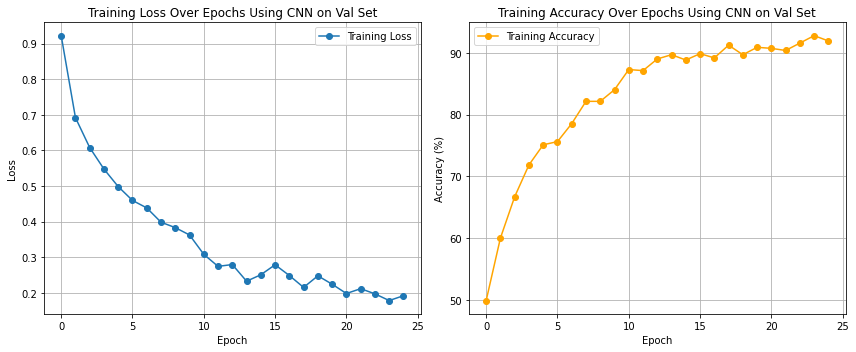

In [32]:
plt.figure(figsize=(12, 5))

# Plotting training loss
plt.subplot(1, 2, 1)
plt.plot(accumulated_losses, label='Training Loss', marker='o')
plt.title('Training Loss Over Epochs Using CNN on Val Set')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plotting training accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracy_history, label='Training Accuracy', marker='o', color='orange')
plt.title('Training Accuracy Over Epochs Using CNN on Val Set')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# 3D CNN + RNN

In [33]:
class ThreeDNetwork(nn.Module):
    def conv_layer(self, in_channels, out_channels, kernel_size, stride=2):
        conv_layer = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size, stride=stride),
            nn.LeakyReLU(),
            nn.MaxPool3d((2, 2, 2)),
            nn.BatchNorm3d(out_channels))
        return conv_layer
    
    def __init__(self, batch_size=BATCH_SIZE):
        super(ThreeDNetwork, self).__init__()
        self.batch_size = batch_size
        self.block1 = nn.Sequential(
            self.conv_layer(1, 64, 3, 2),
            self.conv_layer(64, 128, 3, 2))
        
        # Output features for RNN
        self.feature_extractor = nn.AdaptiveAvgPool3d((1, 1, 1))
        
    def forward(self, x):
        x = self.block1(x)
        x = self.feature_extractor(x)  # Reduce to a single value per feature map
        x = x.view(-1, 128)  # Flatten the features for RNN
        return x

In [34]:
class ThreeDCNNtoRNN(nn.Module):
    def __init__(self, cnn_features_dim, hidden_dim, num_layers, num_classes):
        super(ThreeDCNNtoRNN, self).__init__()
        self.cnn = ThreeDNetwork()  # Your existing CNN
        self.rnn = nn.LSTM(cnn_features_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        batch_size, C, H, W, D = x.size()
        c_out = self.cnn(x)
        c_out = c_out.unsqueeze(1)  # Fake a sequence dimension for LSTM
        r_out, _ = self.rnn(c_out)
        r_out = r_out[:, -1, :]  # Get the last time step output
        output = self.fc(r_out)
        return output


# Instantiate the model
model = ThreeDCNNtoRNN(cnn_features_dim=128, hidden_dim=256, num_layers=1, num_classes=1)  # Update dimensions as needed
print(model)


ThreeDCNNtoRNN(
  (cnn): ThreeDNetwork(
    (block1): Sequential(
      (0): Sequential(
        (0): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2))
        (1): LeakyReLU(negative_slope=0.01)
        (2): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
        (3): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): Sequential(
        (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2))
        (1): LeakyReLU(negative_slope=0.01)
        (2): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
        (3): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (feature_extractor): AdaptiveAvgPool3d(output_size=(1, 1, 1))
  )
  (rnn): LSTM(128, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)


### Training

In [35]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_criterion = nn.BCELoss()
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=4, cooldown=2, verbose=True)

model = model.to(device)
train_criterion = train_criterion.to(device)

In [36]:
num_epochs = 25

accumulated_losses = []
accuracy_history = []  # To store accuracy for each epoch
recorded_best_loss = float('inf')

for current_epoch in range(num_epochs): 
    print(f'Epoch: {current_epoch + 1}')
    batch_losses = []
    epoch_loss_avg = 0
    correct_predictions = 0
    total_predictions = 0
    
    for imgs, labels in train_loader:
        optimizer.zero_grad()
        
        labels_transformed = labels.view(-1, 1).to(torch.float).to(device)
        imgs = imgs.float().to(device)
        
        predictions = model(imgs)
        predictions = torch.sigmoid(predictions)
        loss = train_criterion(predictions, labels_transformed)
        
        loss.backward()
        optimizer.step()
        
        batch_losses.append(loss.item())

        # For accuracy calculation, assuming binary classification and rounding predictions
        predicted_classes = predictions.round().to(device)
        correct_predictions += (predicted_classes == labels_transformed).sum().item()
        total_predictions += labels_transformed.size(0)
            
    epoch_loss_avg = np.mean(batch_losses)
    epoch_accuracy = (correct_predictions / total_predictions) * 100
    accuracy_history.append(epoch_accuracy)  # Append accuracy of this epoch to the history
    
    print(f'Epoch {current_epoch + 1}, Training Loss: {epoch_loss_avg:.4f}, Training Accuracy: {epoch_accuracy:.2f}%')
    
    if epoch_loss_avg < recorded_best_loss:
        torch.save(model.state_dict(), 'updated_model_rnn.pth')
        print('Model performance improved. Saving the new model.')
        recorded_best_loss = epoch_loss_avg
        
    lr_scheduler.step(epoch_loss_avg)
    accumulated_losses.append(epoch_loss_avg)



Epoch: 1
Epoch 1, Training Loss: 0.6977, Training Accuracy: 48.54%
Model performance improved. Saving the new model.
Epoch: 2
Epoch 2, Training Loss: 0.6959, Training Accuracy: 49.23%
Model performance improved. Saving the new model.
Epoch: 3
Epoch 3, Training Loss: 0.6943, Training Accuracy: 52.66%
Model performance improved. Saving the new model.
Epoch: 4
Epoch 4, Training Loss: 0.6932, Training Accuracy: 53.34%
Model performance improved. Saving the new model.
Epoch: 5
Epoch 5, Training Loss: 0.6915, Training Accuracy: 54.72%
Model performance improved. Saving the new model.
Epoch: 6
Epoch 6, Training Loss: 0.6885, Training Accuracy: 55.40%
Model performance improved. Saving the new model.
Epoch: 7
Epoch 7, Training Loss: 0.6861, Training Accuracy: 56.60%
Model performance improved. Saving the new model.
Epoch: 8
Epoch 8, Training Loss: 0.6843, Training Accuracy: 56.43%
Model performance improved. Saving the new model.
Epoch: 9
Epoch 9, Training Loss: 0.6812, Training Accuracy: 57.4

### Testing

In [37]:
model.load_state_dict(torch.load('updated_model_rnn.pth'))

<All keys matched successfully>

In [38]:
acc_correct = 0
samples_total = 0

true_labels = []
predictions = []

# Ensure model is in evaluation mode and gradient computation is off
model.eval()
with torch.no_grad():
    for img_batch, labels in train_loader:
        updated_labels = labels.unsqueeze(1)  # Add an extra dimension
        updated_labels = updated_labels.to(torch.int32).to(device)
        img_batch = img_batch.float().to(device)
        
        pred_logits = model(img_batch)
        pred_probs = torch.sigmoid(pred_logits)
        
        # Apply a custom rounding function to predictions
        rounded_preds = torch.tensor([[rounding(prob)] for prob in pred_probs], dtype=torch.int32).to(device)
        
        samples_total += len(img_batch)
        
        # Calculate number of correct predictions
        correct_preds = (rounded_preds == updated_labels).sum().item()
        acc_correct += correct_preds
        
        # Store predictions and labels for precision and recall calculation
        true_labels.extend(updated_labels.cpu().numpy())
        predictions.extend(rounded_preds.cpu().numpy())

# Calculating overall accuracy
accuracy_pct = (acc_correct / samples_total) * 100

# Calculate precision and recall
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)

print(f'Train Accuracy: {accuracy_pct:.2f} %')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')


Train Accuracy: 48.37 %
Precision: 0.56
Recall: 0.08


In [39]:
from sklearn.metrics import roc_auc_score

# Placeholder for true labels and prediction scores
true_labels = []
pred_scores = []

model.eval()
with torch.no_grad():
    for img_batch, labels in train_loader:
        # Ensure labels are in the correct format
        labels = labels.to(dtype=torch.float32, device=device)
        
        img_batch = img_batch.to(dtype=torch.float32, device=device)
        
        # Get the prediction scores for the positive class
        pred_logits = model(img_batch)
        pred_probs = torch.sigmoid(pred_logits).squeeze().cpu().numpy()  # Assuming binary classification
        
        true_labels.extend(labels.squeeze().cpu().numpy())
        pred_scores.extend(pred_probs)

# Calculate the ROC AUC score
roc_auc = roc_auc_score(true_labels, pred_scores)
print(f'Train ROC AUC: {roc_auc:.2f}')


Train ROC AUC: 0.56


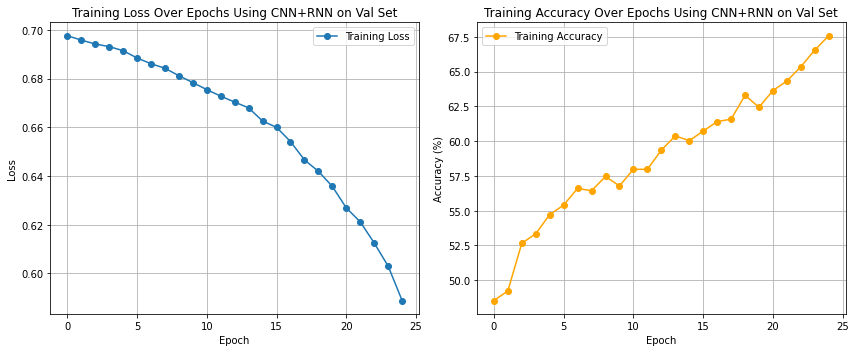

In [40]:
plt.figure(figsize=(12, 5))

# Plotting training loss
plt.subplot(1, 2, 1)
plt.plot(accumulated_losses, label='Training Loss', marker='o')
plt.title('Training Loss Over Epochs Using CNN+RNN on Val Set')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plotting training accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracy_history, label='Training Accuracy', marker='o', color='orange')
plt.title('Training Accuracy Over Epochs Using CNN+RNN on Val Set')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# EfficientNet

In [41]:
pytorch3dpath = "/kaggle/input/efficientnet/pytorch/en/1/EfficientNet-PyTorch-3D-master"

In [42]:
import sys 
sys.path.append(pytorch3dpath)
from efficientnet_pytorch_3d import EfficientNet3D

In [43]:
import torch
from torch import nn

class EfficientNet3DWrapper(nn.Module):
    def __init__(self):
        super().__init__()
        # Assuming EfficientNet3D.from_name is a valid constructor that can create 3D EfficientNet models
        self.net = EfficientNet3D.from_name("efficientnet-b0", override_params={'num_classes': 2}, in_channels=1)
        n_features = self.net._fc.in_features
        self.net._fc = nn.Linear(in_features=n_features, out_features=1, bias=True)
    
    def forward(self, x):
        out = self.net(x)
        return torch.sigmoid(out)


### Train

In [44]:
# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
model = EfficientNet3DWrapper().to(device)

# Print the model summary (optional, requires additional packages like torchsummary)
# from torchsummary import summary
# summary(model, input_size=(1, 64, 64, 64))  # Adjust the size according to your input dimensions


In [45]:
criterion = nn.BCEWithLogitsLoss()  # Appropriate for binary classification with a single output unit

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_criterion = nn.BCELoss()
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=4, cooldown=2, verbose=True)

model = model.to(device)
train_criterion = train_criterion.to(device)

In [46]:
num_epochs = 25

accumulated_losses = []
accuracy_history = []  # To store accuracy for each epoch
recorded_best_loss = float('inf')

for current_epoch in range(num_epochs): 
    print(f'Epoch: {current_epoch + 1}')
    batch_losses = []
    epoch_loss_avg = 0
    correct_predictions = 0
    total_predictions = 0
    
    for imgs, labels in train_loader:
        optimizer.zero_grad()
        
        labels_transformed = labels.view(-1, 1).to(torch.float).to(device)
        imgs = imgs.float().to(device)
        
        predictions = model(imgs)
        predictions = torch.sigmoid(predictions)
        loss = train_criterion(predictions, labels_transformed)
        
        loss.backward()
        optimizer.step()
        
        batch_losses.append(loss.item())

        # For accuracy calculation, assuming binary classification and rounding predictions
        predicted_classes = predictions.round().to(device)
        correct_predictions += (predicted_classes == labels_transformed).sum().item()
        total_predictions += labels_transformed.size(0)
            
    epoch_loss_avg = np.mean(batch_losses)
    epoch_accuracy = (correct_predictions / total_predictions) * 100
    accuracy_history.append(epoch_accuracy)  # Append accuracy of this epoch to the history
    
    print(f'Epoch {current_epoch + 1}, Training Loss: {epoch_loss_avg:.4f}, Training Accuracy: {epoch_accuracy:.2f}%')
    
    if epoch_loss_avg < recorded_best_loss:
        torch.save(model.state_dict(), 'updated_model_en.pth')
        print('Model performance improved. Saving the new model.')
        recorded_best_loss = epoch_loss_avg
        
    lr_scheduler.step(epoch_loss_avg)
    accumulated_losses.append(epoch_loss_avg)



Epoch: 1
Epoch 1, Training Loss: 0.7072, Training Accuracy: 52.49%
Model performance improved. Saving the new model.
Epoch: 2
Epoch 2, Training Loss: 0.7237, Training Accuracy: 52.49%
Epoch: 3
Epoch 3, Training Loss: 0.6928, Training Accuracy: 52.49%
Model performance improved. Saving the new model.
Epoch: 4
Epoch 4, Training Loss: 0.6899, Training Accuracy: 52.49%
Model performance improved. Saving the new model.
Epoch: 5
Epoch 5, Training Loss: 0.6954, Training Accuracy: 52.49%
Epoch: 6
Epoch 6, Training Loss: 0.6957, Training Accuracy: 52.49%
Epoch: 7
Epoch 7, Training Loss: 0.6931, Training Accuracy: 52.49%
Epoch: 8
Epoch 8, Training Loss: 0.6923, Training Accuracy: 52.49%
Epoch: 9
Epoch 9, Training Loss: 0.6941, Training Accuracy: 52.49%
Epoch     9: reducing learning rate of group 0 to 1.0000e-04.
Epoch: 10
Epoch 10, Training Loss: 0.6932, Training Accuracy: 52.49%
Epoch: 11
Epoch 11, Training Loss: 0.6928, Training Accuracy: 52.49%
Epoch: 12
Epoch 12, Training Loss: 0.6923, Trai

### Test

In [47]:
model.load_state_dict(torch.load('updated_model_en.pth'))

<All keys matched successfully>

In [48]:
import torch

# Necessary imports for precision and recall calculation
from sklearn.metrics import precision_score, recall_score

acc_correct = 0
samples_total = 0

true_labels = []
predictions = []

# Ensure model is in evaluation mode and gradient computation is off
model.eval()
with torch.no_grad():
    for img_batch, labels in train_loader:
        updated_labels = labels.unsqueeze(1)  # Add an extra dimension
        updated_labels = updated_labels.to(torch.int32).to(device)
        img_batch = img_batch.float().to(device)
        
        pred_logits = model(img_batch)
        pred_probs = torch.sigmoid(pred_logits)
        
        # Apply a custom rounding function to predictions
        rounded_preds = torch.tensor([[rounding(prob)] for prob in pred_probs], dtype=torch.int32).to(device)
        
        samples_total += len(img_batch)
        
        # Calculate number of correct predictions
        correct_preds = (rounded_preds == updated_labels).sum().item()
        acc_correct += correct_preds
        
        # Store predictions and labels for precision and recall calculation
        true_labels.extend(updated_labels.cpu().numpy())
        predictions.extend(rounded_preds.cpu().numpy())

# Calculating overall accuracy
accuracy_pct = (acc_correct / samples_total) * 100

# Calculate precision and recall
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)

print(f'Train Accuracy: {accuracy_pct:.2f} %')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')


Train Accuracy: 52.49 %
Precision: 0.52
Recall: 1.00


In [49]:
from sklearn.metrics import roc_auc_score

# Placeholder for true labels and prediction scores
true_labels = []
pred_scores = []

model.eval()
with torch.no_grad():
    for img_batch, labels in train_loader:
        # Ensure labels are in the correct format
        labels = labels.to(dtype=torch.float32, device=device)
        
        img_batch = img_batch.to(dtype=torch.float32, device=device)
        
        # Get the prediction scores for the positive class
        pred_logits = model(img_batch)
        pred_probs = torch.sigmoid(pred_logits).squeeze().cpu().numpy()  # Assuming binary classification
        
        true_labels.extend(labels.squeeze().cpu().numpy())
        pred_scores.extend(pred_probs)

# Calculate the ROC AUC score
roc_auc = roc_auc_score(true_labels, pred_scores)
print(f'Train ROC AUC: {roc_auc:.2f}')


Train ROC AUC: 0.56


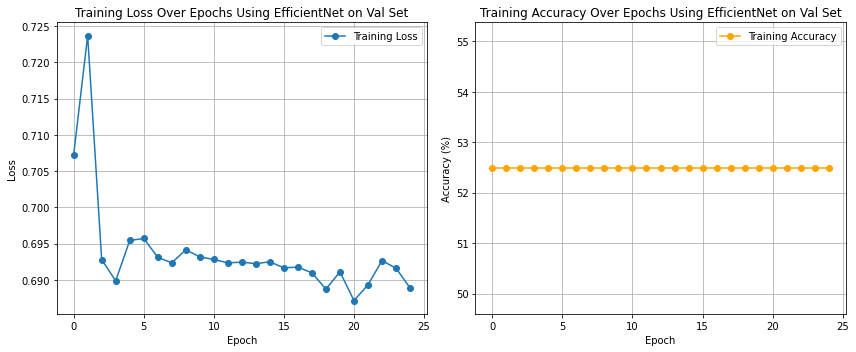

In [50]:
plt.figure(figsize=(12, 5))

# Plotting training loss
plt.subplot(1, 2, 1)
plt.plot(accumulated_losses, label='Training Loss', marker='o')
plt.title('Training Loss Over Epochs Using EfficientNet on Val Set')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plotting training accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracy_history, label='Training Accuracy', marker='o', color='orange')
plt.title('Training Accuracy Over Epochs Using EfficientNet on Val Set')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


References:
https://www.kaggle.com/ammarnassanalhajali/brain-tumor-3d-training
https://www.kaggle.com/code/vexxingbanana/simple-pytorch-cnn